<a href="https://colab.research.google.com/github/abyanjan/Multivariate-Timeseries-modeling-with-LSTM/blob/master/Multivariate_TimeSeries_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MULTIVARIATE TIMESERIES MODELING WITH LSTM AND TENSORFLOW

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

### DATA

The data for the modeling is downloaded from https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv

The data contains energy consumption of household appliances usage. The data contains information at every 10 mins.

In [ ]:
# read data
#df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')
df = pd.read_csv('https://raw.githubusercontent.com/LuisM78/Appliances-energy-prediction-data/master/energydata_complete.csv')

In [ ]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
# data size
df.shape

(19735, 29)

**Columns Description**
- date : time year-month-day hour:minute:second
- Appliances: energy use in Wh
- lights : energy use of light fixtures in the house in Wh
- T1: Temperature in kitchen area, in Celsius
- RH1: Humidity in kitchen area, in % T2, Temperature in living room area, in  Celsius 
- RH2: Humidity in living room area, in %
- T3: Temperature in laundry room area
- RH3: Humidity in laundry room area, in % 
- T4: Temperature in office room, in Celsius 
- RH4: Humidity in office room, in %
- T5: Temperature in bathroom, in Celsius
- RH5: Humidity in bathroom, in % 
- T6: Temperature outside the building (north side), in Celsius 
- RH6: Humidity outside the building (north side), in %
- T7: Temperature in ironing room , in Celsius
- RH7: Humidity in ironing room, in % 
- T8: Temperature in teenager room 2, in Celsius 
- RH8: Humidity in teenager room 2, in %
- T9: Temperature in parents room, in Celsius
- RH9: Humidity in parents room, in % 
- T_out: Temperature outside (from Chievres weather station), in Celsius
- Press_mm_hg : Presuure(from Chievres weather station), in mm Hg 
- RH_out: Humidity outside (from Chievres weather station), in %
- Wind speed: (from Chievres weather station), in m/s
- Visibility: (from Chievres weather station), in km
- Tdewpoint: (from Chievres weather station), Â°C
- rv1: Random variable 1, nondimensional
- rv2: Random variable 2, nondimensional

Column Appliances represents the total energy cunsumption. So, it is the target feature we will be predicting.

In [ ]:
# data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [ ]:
# converting date to date time format
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

**Visualizing**  

Visualizing some of the columns in the data.

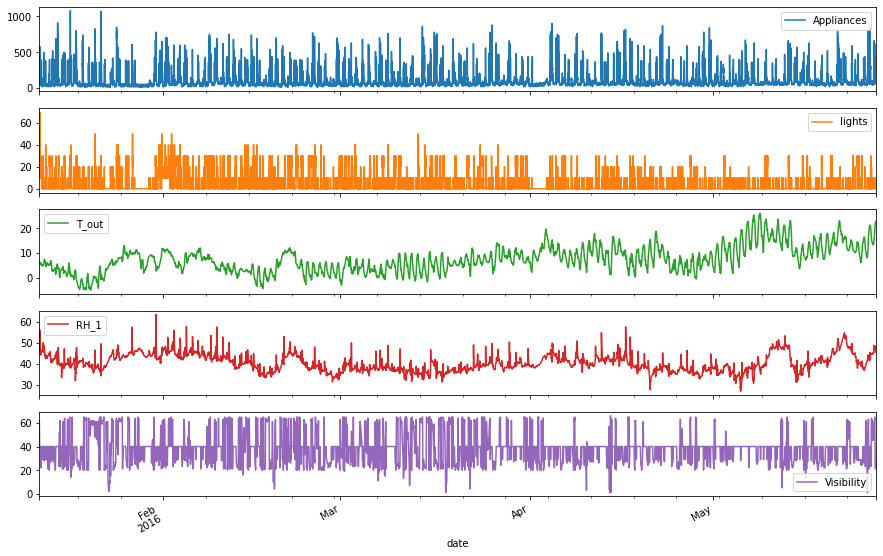

In [ ]:
df.set_index('date')[['Appliances', 'lights','T_out', 'RH_1', 'Visibility']].plot(subplots=True, figsize=(15,10));

**SubSetting Data for the Modeling**

In [ ]:
df_input = df[['Appliances','T_out', 'RH_1', 'Visibility']]
df_input.head(10)

,Appliances,T_out,RH_1,Visibility
0,60,6.600000,47.596667,63.000000
1,60,6.483333,46.693333,59.166667
2,50,6.366667,46.300000,55.333333
3,50,6.250000,46.066667,51.500000
4,60,6.133333,46.333333,47.666667
5,50,6.016667,46.026667,43.833333
6,60,5.900000,45.766667,40.000000
7,60,5.916667,45.560000,40.000000
8,60,5.933333,45.597500,40.000000
9,70,5.950000,46.090000,40.000000


In [ ]:
df_input.describe()

,Appliances,T_out,RH_1,Visibility
count,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,7.411665,40.259739,38.330834
std,102.524891,5.317409,3.979299,11.794719
min,10.000000,-5.000000,27.023333,1.000000
25%,50.000000,3.666667,37.333333,29.000000
50%,60.000000,6.916667,39.656667,40.000000
75%,100.000000,10.408333,43.066667,40.000000
max,1080.000000,26.100000,63.360000,66.000000


**Train Test Split**

In [ ]:
# separating target and features
#target = df_input["Appliances"]

In [ ]:
# train_test split
x_train, x_test = train_test_split(df_input, test_size=0.20, random_state=123, shuffle = False)

In [ ]:
x_train.shape, x_test.shape

((15788, 4), (3947, 4))

In [ ]:
# scaling the data
scaler = MinMaxScaler()
scaler.fit(x_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
# transform data
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
# get the traget , which is the Appliances, that is the first column
y_train = x_train[:,0]
y_test = x_test[:,0]

### Modeling Time Series with LSTM

**Creating Time Series Generator**

In [ ]:
# taking 5 days of data as sequence input to predict the next output
# the data has information on every 10 mins so for 5 days the time length 
# becomes 720 (= 6 * 24 *5 )

win_length=720

batch_size=32
num_features=4

train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [ ]:
# example of a train generator
train_generator[0]

(array([[[0.04672897, 0.46963563, 0.55754117, 0.95384615],
         [0.04672897, 0.46491228, 0.53218563, 0.89487179],
         [0.03738318, 0.46018893, 0.52114521, 0.83589744],
         ...,
         [0.06542056, 0.31781377, 0.30220808, 0.79230769],
         [0.05607477, 0.30094467, 0.2994012 , 0.72820513],
         [0.06542056, 0.28407557, 0.29734281, 0.66410256]],
 
        [[0.04672897, 0.46491228, 0.53218563, 0.89487179],
         [0.03738318, 0.46018893, 0.52114521, 0.83589744],
         [0.03738318, 0.45546559, 0.51459581, 0.77692308],
         ...,
         [0.05607477, 0.30094467, 0.2994012 , 0.72820513],
         [0.06542056, 0.28407557, 0.29734281, 0.66410256],
         [0.06542056, 0.26720648, 0.29547156, 0.6       ]],
 
        [[0.03738318, 0.46018893, 0.52114521, 0.83589744],
         [0.03738318, 0.45546559, 0.51459581, 0.77692308],
         [0.04672897, 0.45074224, 0.52208084, 0.71794872],
         ...,
         [0.06542056, 0.28407557, 0.29734281, 0.66410256],
        

In [ ]:
# Defining LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 720, 128)          68096     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 720, 128)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 720, 128)          131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 720, 128)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 720, 128)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

In [ ]:
# compile the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
# train the model
history = model.fit_generator(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
471/471 [==============================] - 44s 86ms/step - loss: 0.0116 - mean_absolute_error: 0.0624 - val_loss: 0.0060 - val_mean_absolute_error: 0.0529
Epoch 2/50
471/471 [==============================] - 40s 84ms/step - loss: 0.0087 - mean_absolute_error: 0.0505 - val_loss: 0.0045 - val_mean_absolute_error: 0.0390
Epoch 3/50
471/471 [==============================] - 39s 84ms/step - loss: 0.0060 - mean_absolute_error: 0.0400 - val_loss: 0.0033 - val_mean_absolute_error: 0.0286
Epoch 4/50
471/471 [==============================] - 40s 84ms/step - loss: 0.0049 - mean_absolute_error: 0.0345 - val_loss: 0.0033 - val_mean_absolute_error: 0.0322
Epoch 5/50
471/471 [==============================] - 40s 84ms/step - loss: 0.0047 - mean_absolute_error: 0.0333 - val_loss: 0.0032 - val_mean_absolute_error: 0.0290
Epoch 6/50
471/471 [==============================] - 40s 84ms/step - loss: 0.0046 - mean_absolute_error: 0.0334 - val_loss: 0.0033 - val_mean_absolute_error: 0.0305
Epoc

In [ ]:
# evaluation on test data
loss, mae = model.evaluate(test_generator)
print(f'loss:{loss}')
print(f'MAE:{mae}')

101/101 [==============================] - 4s 35ms/step - loss: 0.0032 - mean_absolute_error: 0.0276
loss:0.0031918776221573353
MAE:0.027597645297646523


In [ ]:
# make predictions
preds = model.predict(test_generator)
preds

array([[0.06853656],
       [0.09934511],
       [0.12182746],
       ...,
       [0.08585144],
       [0.26965034],
       [0.2618147 ]], dtype=float32)

In [ ]:
preds.shape

(3227, 1)

In [ ]:
x_test.shape

(3947, 4)

We can see that the predictions contains less data points than the test data. It is because the model takes first 720 data points(window length) as the input to predict the next output. So, we will not have any output for the first 720 data points.

In [ ]:
# creating the data set with the inputs and the predicted values
# replace the value for Appliances with the predicted values in the test data

df_pred = pd.concat([pd.DataFrame(preds),pd.DataFrame(x_test[:,1:][win_length:])], axis = 1)
df_pred.columns = df_input.columns

In [ ]:
df_pred.head()

,Appliances,T_out,RH_1,Visibility
0,0.068537,0.570850,0.192740,0.6
1,0.099345,0.593117,0.166542,0.6
2,0.121827,0.615385,0.168413,0.6
3,0.348692,0.637652,0.177933,0.6
4,0.141340,0.659919,0.165513,0.6


In [ ]:
# inverse transform to bring back to original scale
df_pred = pd.DataFrame(scaler.inverse_transform(df_pred), columns = list(df_input.columns))
df_pred.head(10)

,Appliances,T_out,RH_1,Visibility
0,83.334124,9.100000,34.600000,40.0
1,116.299268,9.650000,33.666667,40.0
2,140.355383,10.200000,33.733333,40.0
3,383.100121,10.750000,34.072500,40.0
4,161.234169,11.300000,33.630000,40.0
5,126.993303,11.633333,32.900000,40.0
6,85.391107,11.966667,32.760000,40.0
7,125.116881,12.300000,32.400000,40.0
8,97.107446,12.633333,32.200000,40.0
9,98.423604,12.966667,32.290000,40.0


In [ ]:
df_pred.shape

(3227, 4)

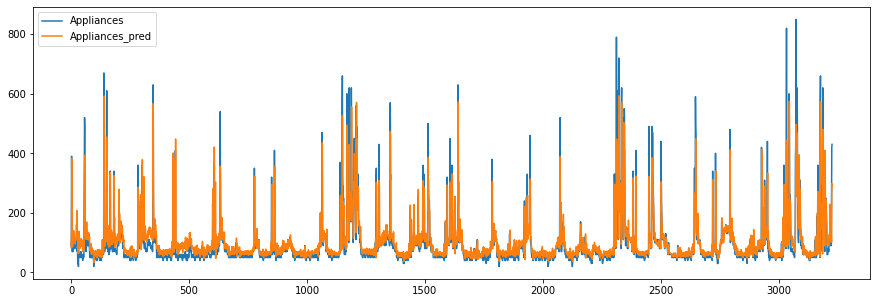

In [ ]:
# plotting the actual values against the predicted values
actual = scaler.inverse_transform(x_test[win_length:,:])

plt.figure(figsize=(15,5))
plt.plot(actual[:,0], label = "Appliances")
plt.plot(df_pred["Appliances"], label = "Appliances_pred")
plt.legend()
plt.show()

We see that the predictions are very close to the acutal values, but the model misses out in the peack data points.